In [1]:
!pip install scikeras[tensorflow]

In [2]:
#import keras
import tensorflow
from tensorflow import keras
import numpy as np
import pandas as pd
import random
import sklearn
import time
import matplotlib.pyplot as plt
import os
import sys

#from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm import tqdm
from tensorflow.keras.callbacks import History, ModelCheckpoint
from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation 
from tensorflow.keras import layers

from utils import *

2023-09-22 19:23:39.058161: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 19:23:39.690328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tensorflow.test.gpu_device_name()

2023-09-22 19:23:42.489159: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 21094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c4:00.0, compute capability: 8.6


'/device:GPU:0'

In [4]:
# ensure reproducibilities
seed = False
if seed:
    SEED = 3
    
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

In [5]:
robot_choice = "3DoF-R"
if robot_choice == "3DoF-R":
    n_DoF = 3
    input_dim = 2
    output_dim = 3
data = pd.read_csv('data_'+robot_choice+'.csv')
data

,x,y,t1,t2,t3
0,0.908878,0.972347,-0.023520,1.685287,-2.585673
1,-1.603698,-0.366326,-2.312021,-1.209998,0.842441
2,0.241596,0.591827,-0.062245,2.490936,-0.278798
3,1.666944,0.620960,0.831305,-0.949430,-0.617528
4,-0.628984,0.792674,-3.001316,-2.080621,-1.295037
...,...,...,...,...,...
9995,0.066960,-0.313310,0.049666,-2.819821,-2.962427
9996,1.448904,-0.102334,-0.828447,1.515872,0.478921
9997,0.289784,0.069563,1.656825,-2.842462,-2.148063
9998,0.558301,-1.918480,-1.243619,-0.087972,1.720874


[Text(0.5, 0, 'x(m)'), Text(0, 0.5, 'y(m)'), Text(0.5, 1.0, 'theta 3')]

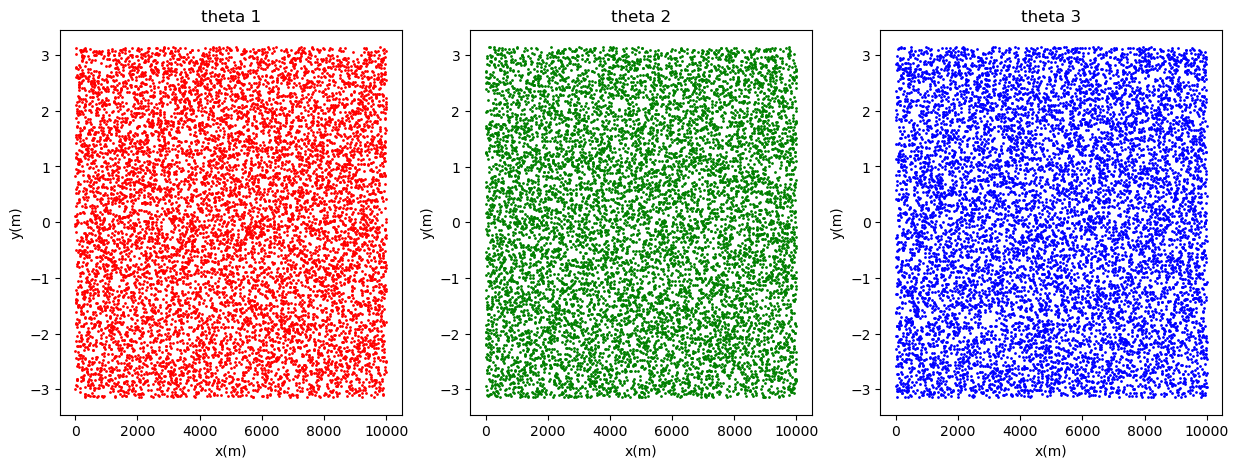

In [6]:
# visualize joints
data_a = np.array(data) 
n_samples = data_a.shape[0]
values = np.linspace(1,n_samples,n_samples)

fig, axs = plt.subplots(1,3, figsize=(15, 5)) #, sharex=True, sharey=True)
axs[0].scatter(values, data_a[:,2],s=1, marker='o', c='r')
axs[0].set(xlabel='x(m)', ylabel='y(m)', title='theta 1')
axs[1].scatter(values, data_a[:,3],s=1, marker='o', c='g')
axs[1].set(xlabel='x(m)', ylabel='y(m)', title='theta 2')
axs[2].scatter(values, data_a[:,4],s=1, marker='o', c='b')
axs[2].set(xlabel='x(m)', ylabel='y(m)', title='theta 3')


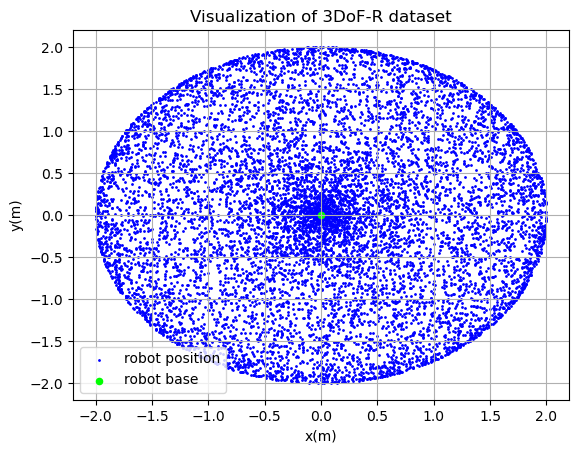

In [7]:
# visualize workspace
fig, ax = plt.subplots()
ax.scatter(data_a[:,0], data_a[:,1],s=1, marker='o', c='b')
ax.scatter(0,0,s=20, marker='o', c='lime')
ax.set(xlabel='x(m)', ylabel='y(m)',
       title='Visualization of '+robot_choice+ ' dataset')
ax.legend(["robot position","robot base"])
ax.grid()

In [8]:
def MLP_Keras():
    model = Sequential()
    model.add(layers.Dense(32, input_dim=2, kernel_initializer='normal', activation='relu'))             # 7 inputs neurons - 32 hidden neurons in hidden layer 1
    model.add(layers.Dense(64, kernel_initializer='normal', activation='relu'))                          # 64 hidden neurons in hidden layer 2                          
    model.add(layers.Dense(128, kernel_initializer='normal', activation='relu'))                         # 128 hidden neurons in hidden layer 3
    model.add(layers.Dense(32, kernel_initializer='normal', activation='relu'))                          # 32 hidden neurons in hidden layer 4
    model.add(layers.Dense(3, kernel_initializer='normal', activation='relu'))                           # 4 output neurons in the ouput layer
    #opt = Optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=True)                          # Setting nesterov = True, applies the nesterov SGD
    opt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.0, nesterov=True) 
    #opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
    model.summary()    
    model.save_weights('model.hdf5')
    return model


# function to load the dataset
def load_dataset(data, n_DoF):
    
    X = data[:,:2]
    y = data[:,2:]        
    #y = data[:,:2]
    #X = data[:,2:]
        
    # split in train and test sets
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, 
                                                                y, 
                                                                test_size = 0.1,
                                                                random_state = 1)

    sc_in = MinMaxScaler(copy=True, feature_range=(-1, 1))
    sc_out = MinMaxScaler(copy=True, feature_range=(-1, 1))
    
    X_train = sc_in.fit_transform(X_train_i)
    X_test = sc_in.transform(X_test_i)  

    #y_train = sc_out.fit_transform(y_train)
    #y_test = sc_out.transform(y_test) 
    return X_test, y_test_i, X_train, y_train_i

# This function plots the learning curves in real time (accuracies and losses)
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20), sharex=True)
        f.suptitle("Plots of the losses and accuracies", fontsize=16)
        
        clear_output(wait=True)        
        
        ax1.set_yscale('log')        
        ax1.set_title("Training and Validation Losses")
        ax1.set_xlabel('Number of epochs')
        ax1.plot(self.x, self.losses, label="Training loss", linewidth=3)
        ax1.plot(self.x, self.val_losses, label="Validation loss", linewidth=3)
        ax1.legend()
        
        """
        ax2.set_title("Training and Validation Accuracies")
        ax2.set_xlabel('Number of epochs')
        ax2.plot(self.x, self.acc, label="Training accuracy", linewidth=3)
        ax2.plot(self.x, self.val_acc, label="Validation accuracy", linewidth=3)
        ax2.legend()
        """
        
        #plt.title('Plots of the losses and accuracies')
        plt.show();

In [9]:
X_test, y_test, X_train, y_train = load_dataset(data_a, n_DoF)

In [10]:
## train and validate
#training = KerasRegressor(model=MLP_Keras, batch_size=32)

save_path = "weights_keras"
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
checkpoint = ModelCheckpoint(save_path+"/weights.h5", save_best_only=True, save_weights_only=True)
plot_losses = PlotLearning()
callbacks_list = [checkpoint]
#history_01 = training.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), callbacks=callbacks_list, verbose=2, shuffle=True)
mlp = MLP_Keras()
mlp.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), verbose=2, shuffle=True)



from numba import cuda
device = cuda.get_current_device()
device.reset()

2023-09-22 19:23:45.330447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c4:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 14755 (57.64 KB)
Trainable params: 14755 (57.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000


2023-09-22 19:23:46.871081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-22 19:23:46.873273: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561c6c7e5c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-22 19:23:46.873293: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-09-22 19:23:46.987363: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:425] Loaded runtime CuDNN library: 8.5.0 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2023-09-22 19:23:46.9881

FailedPreconditionError: Graph execution error:

Detected at node 'SGD/StatefulPartitionedCall_8' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/opt/conda/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_13377/1922522221.py", line 13, in <module>
      mlp.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), verbose=2, shuffle=True)
    File "/opt/conda/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 544, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1230, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1260, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1352, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1347, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'SGD/StatefulPartitionedCall_8'
DNN library initialization failed. Look at the errors above for more details.
	 [[{{node SGD/StatefulPartitionedCall_8}}]] [Op:__inference_train_function_1000]